https://github.com/farizrahman4u/seq2seq
    
1. Seq2Seq(sequence-to-sequence)이란? :

    - Seq2Seq의 구조
    
    a. seq2seq 시퀀스를 받고 다른 시퀀스로 변환하는 모델로, 문장 등의 입력을 압축하는 encoder와 출력을
    전개하는 decoder로 구성
    
    b. encoder와 decoder에 각각 RNN층이 구축되어 encoder와 decoder를 연결시킴으로써 seq2seq가 만들어진다.
    
    c. '나는 펜을 가지고있다'라는 문장을 'I have a pen'라는 영문으로 번역하는 것이 가능하다
       '대화문장 응답'
           
    - Encoder : 각 시간마다 시계열 데이터(문장)으로 입력된다.
            -> RNN(LSTM) 입력된 시퀀스를 처리한다. -> RNN의 출력결과 -> 시퀀스 결과를 가진다.
    
    - Decoder :문장이 순서대로 주어지면 대상 시퀀스의 다음문자를 예측하도록 훈련된다.
           -> RNN의 출력결과는 무시하고 다음 문자를 예측한다.
    
    - 추론단계 : 입력단어(시퀀스 : 영문) -> 벡터변환 -> LSTM층을 이용해서 Encoder가 된다. 
    
        -> 입력데이터를 내부상태로 변환 과정을 가진다. (1문장의 대상 시퀀스를 Decoder에 입력하고) 다음 문장의 변환 과정을 가진다. 
        
        -> 다음 문장을 한글로 선택하는 샘플링 작업 -> 샘플링한 단어를 정답으로 내보낸다. 
        
        -> Decoder에서 출력된 대상 시퀀스와 내부상태작업을 가진 데이터가 순차적으로 Decoder에게 전달 
        
        -> 시퀀스의 종류문자가 생성될 때 까지 반복
    
    
2. LSTM 연동
   - Encoder : LSTM 층을 이용해서 영문시퀀스를 입력하게 되면 2개의 값을 출력한다. (input, states_내부상태값)
   
   - Decoder : states_내부상태값을 초기상태로 지정해서 사용하게 된다.
   
   
- Encoder
   encoder_input   ->   LSTM(encoder_lstm)  ->  (encoder_output, state_h, state_c) -> state
                       return sequences = False
                       return state = True

- Decoder
   state(초기) ->  LSTM(decoder_lstm)     ->  (decoder_output, state_h, state_c) -> dense -> decoder_output
                return sequences = False
                return state = True
    
    -> translated(변환)

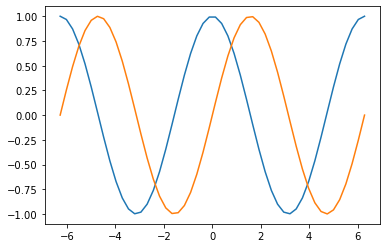

(40, 10)
(40, 10)
(40, 10)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# step 1) 데이터 생성
# 1) 훈련용 데이터 생성
# cos 함수값은 encoder, sin 함수값은 decoder에 입력
# 정답 sin 함수
x_ax = np.linspace(-2*np.pi, 2*np.pi)  # -2π에서 2π까지 50개의 값
cos_data = np.cos(x_ax)
sin_data = np.sin(x_ax)

plt.plot(x_ax, cos_data)
plt.plot(x_ax, sin_data)
plt.show()

# 2) 인코더와 디코더의 모양을 만들자
# 시계열 수를 10으로 지정
n_rnn = 10   # 시계열 수
n_sample = len(x_ax) - n_rnn   # 샘플

x_encoder = np.zeros((n_sample, n_rnn))   # encoder 입력
x_decoder = np.zeros((n_sample, n_rnn))   # decoder 입력
t_decoder = np.zeros((n_sample, n_rnn))   # decoder 출력

print(x_encoder.shape)
print(x_decoder.shape)
print(t_decoder.shape)

# 3) x_encoder에 cos 함수값을 지정하고 x_decoder에 sin 값을 지정한다.
for i in range(0, n_sample):
    x_encoder[i] = cos_data[i:i+n_rnn]
    x_decoder[i, 1:] = sin_data[i:i+n_rnn-1]
    
# 4) t_decoder에 sin 값을 그대로 대입
for j in range(0, n_sample):
    t_decoder[j] = cos_data[j:j+n_rnn]
    
# 5) 뉴런 데이터 형으로 변환
x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)

step 2) Seq2Seq 구축(학습 모델 구축, 예측 모델 구축)

 1. 학습 모델 구축(모델 설정) : Model 해당 클래스만 사용. LSTM 사용
 2. 학습 모델 구축(encoder 구축)
 3. 학습 모델 구축(decoder 구축)
 4. 학습 모델 구축(모델 컴파일)
 5. 학습 모델 구축(학습 모델 구축한 것을 학습 실시)
 6. 학습 모델 구축(학습 값을 확인)
 7. 예측 모델 구축(encoder 구축)
 8. 예측 모델 구축(decoder 구축)
 9. 번역에 대한 함수를 정의

In [3]:
# step 2) Seq2Seq 구축(학습 모델 구축, 예측 모델 구축)
# 1) 학습 모델 구축(모델 설정) : Model 해당 클래스만 사용. LSTM 사용
from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1   # 입력층의 뉴런 수
n_mid = 20   # 중간층의 뉴런 수
n_out = n_in   # 출력층의 뉴런 수

encoder_input = Input(shape=(n_rnn, n_in))   # 시계열 수, 입력층 수

encoder_lstm = LSTM(n_mid, return_state=True)
# 중간층(return_state = True : 해당 시간 출력 ht, 상태를 리턴)

#  2) 학습 모델 구축(encoder 구축)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h, encoder_state_c]

encoder_state

[<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'lstm')>]

In [4]:
#  3) 학습 모델 구축(decoder 구축)
decoder_input = Input(shape=(n_rnn, n_in))   # decoder 입력 레이어
decoder_lstm = LSTM(n_mid, return_sequences=True, return_state=True)

# decoder에서 출력한 상태는 전혀 사용하지 않는다
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_state)  # initial_state : 초기값
decoder_dense = Dense(n_out, activation='linear')   # 결합층
decoder_output = decoder_dense(decoder_output)

decoder_output

<KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'dense')>

In [5]:
# 4) 학습 모델 구축(모델 컴파일)
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss='mean_squared_error', optimizer='sgd')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (None,  1760        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 10, 20), (No 1760        input_2[0][0]                    
                                                                 lstm[0][1]                   

In [6]:
# 5) 학습 모델 구축(학습 모델 구축한 것을 학습 실시)
history = model.fit([x_encoder, x_decoder], t_decoder, batch_size=8, epochs=30)

Epoch 1/30
5/5 [==============================] - 2s 4ms/step - loss: 0.6024
Epoch 2/30
5/5 [==============================] - 0s 4ms/step - loss: 0.5609
Epoch 3/30
5/5 [==============================] - 0s 3ms/step - loss: 0.5240
Epoch 4/30
5/5 [==============================] - 0s 3ms/step - loss: 0.5026
Epoch 5/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4936
Epoch 6/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4791
Epoch 7/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4516
Epoch 8/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4394
Epoch 9/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4411
Epoch 10/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4149
Epoch 11/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4202
Epoch 12/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4152
Epoch 13/30
5/5 [==============================] - 0s 3ms/step - loss: 0.

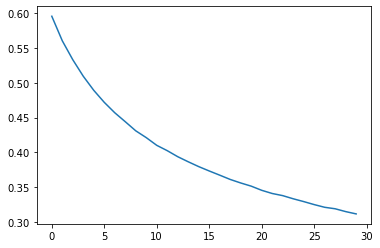

In [7]:
#  6) 학습 모델 구축(학습 값을 확인)
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

In [8]:
# 7) 예측 모델 구축(encoder 구축)
# encoder는 수신상태로 리턴하고 decoder는 입력과 상태값을 받아서 출력상태를 리턴
# encoder_input - encoder_lstm = encoder_state
encoder_model = Model(encoder_input, encoder_state)

# 8) 예측 모델 구축(decoder 구축)
decoder_input = Input(shape=(1, n_in))
decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]
decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input, initial_state=decoder_state_in)

decoder_state = [decoder_state_h, decoder_state_c]
decoder_output = decoder_dense(decoder_output)

# 각각 리스트 값을 유지하고 있으면, 입력으로 전달할 때 각 목록을 결합해서 전달 +를 쓴다
decoder_model = Model([decoder_input]+decoder_state_in, [decoder_output]+decoder_state)

In [9]:
# 9) 번역에 대한 함수를 정의 : 코사인함수 번역해서 사인 함수 변환 함수
# encoder 입력값을 예측 모델에 적용하는 함수
def translate(input_data):
    translated = []
    # LSTM 예측, 출력은 내부상태, h, c 2가지가 리턴
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, 1))
    
    for i in range(0, n_rnn):
        # 시간상태h, 목록c - decoder_model 학습된 LSTM과 Dense에 대한 예측률이 들어간다
        y, h, c = decoder_model.predict([y_decoder] + state_value)
        y = y[0][0][0]   # 출력값 y에서 번역된 값을 출력
        translated.append(y)
        y_decoder[0][0][0] = y   # 다음 시간에 전달 할 값
        state_value = [h, c]   # 다음 시간에 전달 할 상태
        
    return translated

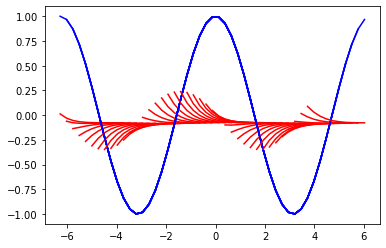

In [10]:
# 10) 시각화
idices = range(0, 40)
for indice in idices:
    x = x_encoder[indice:indice+1]
    y = translate(x)
    
    plt.plot(x_ax[indice:indice+n_rnn], x.reshape(-1), color='b')
    plt.plot(x_ax[indice:indice+n_rnn], y, color='r')
    
plt.show()

In [11]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/kor-eng.zip'
filename = 'kor-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)

with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)
    
with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)
    
#%%    
lines= pd.read_csv('kor.txt', names=['src', 'tar', 'cc'], sep='\t')
print( len(lines) )

#%%
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
print( lines.sample(10) )

#%%
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
print(lines.sample(10))

#%%
# 글자 집합 구축
src_vocab=set()

for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)
tar_vocab=set()

for line in lines.tar:
    for char in line:
        tar_vocab.add(char)
        
print(src_vocab)  

#%%
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size) 

#%%
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

#%%
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

#%%
encoder_input = []

for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
    
print(encoder_input[:5])

#%%
decoder_input = []

for line in lines.tar:
    temp_X = []
    for w in line:
      temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

#%%
decoder_target = []

for line in lines.tar:
    t=0
    temp_X = []
    for w in line:
      if t>0:
        temp_X.append(tar_to_index[w])
      t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])

#%%
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

#%%
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')
print(encoder_input)

#%%
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

#%%
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

#%%  모델 구축
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.

#%%
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

#%%
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=50, validation_split=0.2)
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.
    stop_condition = False
    decoded_sentence = ""
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char
        
        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.
        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]
    return decoded_sentence

for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력


3648
                                                    src  \
110                                           What fun!   
702                                   Choose carefully.   
3525  I don't have much money, but I can get along s...   
2504                   Tom really made me feel at home.   
1341                            May I see your license?   
734                                   I'm not suicidal.   
2875               What's your favorite kind of cheese?   
2869               Tom said he spoke to Mary yesterday.   
664                                    Might I come in?   
1399                           Ants are social insects.   

                                tar  
110                           재밌잖아!  
702                        신중하게 골라.  
3525     나는 돈이 별로 없지만, 그럭저럭 지낼 수 있다  
2504  톰은 내가 마치 집에 있는 것처럼 편안하게 해주었어.  
1341            당신의 라이센스를 봐도 되겠습니까?  
734                  나는 자살하고 싶지 않다.  
2875             어떤 종류의 치즈를 가장 좋아해?  
2869     톰이 말하길 자기가 어제 마리한테 말을 걸었대.  
664

Epoch 1/50
46/46 [==============================] - 156s 3s/step - loss: 1.6504 - val_loss: 0.4946
Epoch 2/50
46/46 [==============================] - 153s 3s/step - loss: 0.2421 - val_loss: 0.5002
Epoch 3/50
46/46 [==============================] - 168s 4s/step - loss: 0.2393 - val_loss: 0.4404
Epoch 4/50
46/46 [==============================] - 171s 4s/step - loss: 0.2216 - val_loss: 0.4236
Epoch 5/50
46/46 [==============================] - 158s 3s/step - loss: 0.2084 - val_loss: 0.4068
Epoch 6/50
46/46 [==============================] - 155s 3s/step - loss: 0.1878 - val_loss: 0.3639
Epoch 7/50
46/46 [==============================] - 153s 3s/step - loss: 0.1790 - val_loss: 0.3615
Epoch 8/50
46/46 [==============================] - 151s 3s/step - loss: 0.1681 - val_loss: 0.3325
Epoch 9/50
46/46 [==============================] - 152s 3s/step - loss: 0.1618 - val_loss: 0.3453
Epoch 10/50
46/46 [==============================] - 154s 3s/step - loss: 0.1544 - val_loss: 0.3188
Epoch 11/

In [12]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# 번역 데이터셋이 있는 사이트에 접속해서 프랑스어와 영어 번역 데이터를 다운받는다.
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)

with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)
    
# 다운받은 파일을 압축을 푼다.
with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)
    
# 프랑스어와 영어번역 text 파일을 읽어서 보여준다.
lines= pd.read_csv('fra.txt', names=['src', 'tar', 'cc'], sep='\t')
print( len(lines) )
lines

185583


,src,tar,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
185578,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
185579,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
185580,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
185581,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


HOG - Histogram of Oriented Gradients

: 영상의 지역적 그래디언트 방향 정보를 히스토그램으로 표현해서 영상의 형태를 표현하는 방법

foundLocations(검출된 사각형 영역 정보), foundWeights(검출된 사각형영역가중치) 

=cv2.HOGDescriptor.detectMultiScale( 

img, 입력 영상 

hitThreshold=None, 특징 벡터와 SVM 분류 평면까지의 거리에 대한 임계값 

winStride=None, 셀 윈도우 이동 크기 

padding=None, 패딩 크기 

scale=None, 검색 윈도우 크기 확대 비율 

finalThreshold=None, 검출 결정을 위한 임계값 

useMeanshiftGrouping=None 겹쳐진 검색 윈도우를 합치는 플래그 ) 

-> foundLocations, foundWeights

hog = cv2.HOGDescriptor() 

hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

hogParams = {'hitThreshold' : 0.0,'winStride': (8, 8), 'padding': (32, 32), 'scale': 

1.05,'finalThreshold':2,'useMeanshiftGrouping':False}


In [3]:
import numpy as np
import cv2

cap = cv2.VideoCapture('C:\\test\\People2.mp4')
cap # < VIdeoCapture >

# 프레임의 가로 세로 fps 값 리턴 받기
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
writer = cv2.VideoWriter('C:\\test\\People_res.mp4', fourcc, fps, (width, height))

# 움직이는 대상을 인식하는 객체
hog = cv2.HOGDescriptor( (48, 96), (16, 16), (8, 8), (8, 8), 9 )  
hog.setSVMDetector(cv2.HOGDescriptor_getDaimlerPeopleDetector())
hogParams = {'hitThreshold' : 0.0,'winStride': (8, 8), 'padding': (32, 32),'scale':1.05,'finalThreshold':2,'useMeanshiftGrouping':True}

while(1):
    ret, frame = cap.read()
    if frame is None:
        break
    h, r = hog.detectMultiScale(frame, **hogParams)
    
    for (x,y,w,h) in h:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,50,255), 3)
    
    cv2.imshow('frame', frame)
    writer.write(frame)
    
    key = cv2.waitKey(30) & 0xff
    if key == 27 :
        break

cap.release()
writer.release()
cv2.destroyAllWindows()
        

In [15]:
import numpy as np
import cv2

img = cv2.imread('c:\\test\\people.jpg')

hog = cv2.HOGDescriptor()  
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

hogParams = {'winStride': (8, 8), 'padding': (32, 32),'scale':1.05 }

h, r = hog.detectMultiScale(img, **hogParams)
    
for (x,y,w,h) in h:
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,0), 3)
    
cv2.imshow('img', img)
cv2.imwrite('c:\\test\\res_img.png', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
        